# Lab 5: End-to-End Speech-to-Text Summarization / Topic Modeling (ipynb)



In [1]:
!pip install SpeechRecognition
!pip install pydub
!pip install ffmpeg-python
!pip install nltk
!pip install scikit-learn
!pip install matplotlib
!pip install openai-whisper






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 5.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=6fe003d4c1bb56be4c8520a49ee558f33b183060c65a5c4a04dd8d0c35e4860d
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [2]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import speech_recognition as sr
import whisper
import re

from IPython.display import Audio
from pydub import AudioSegment
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


## 1) Što je ASR (Automatic Speech Recognition)

Automatic Speech Recognition (ASR) predstavlja skup metoda i algoritama za automatsku pretvorbu govornog signala u pisani tekst. U okviru ovog laboratorijskog zadatka ASR čini ulaznu komponentu end-to-end sustava, u kojem se govorni signal postupno transformira u strukturirani tekstualni uvid, poput sažetka ili skupa tematskih pojmova.

Kvaliteta izlaza ASR-a izravno utječe na uspješnost svih kasnijih faza obrade, uključujući normalizaciju teksta, ekstraktivno sažimanje i topic modeling. Pogreške nastale u fazi prepoznavanja govora često se prenose kroz cijeli sustav, što naglašava važnost razumijevanja ograničenja i karakteristika ASR tehnologije.


##ASR sustav tipično prolazi kroz ova tri sloja:

**1. Ekstrakcija značajki iz audio signala**

Govorni signal se pretvara u numeričku reprezentaciju koja opisuje relevantne akustičke karakteristike. Najčešće se koriste Mel-frekvencijski koeficijenti ili Mel-spektrogrami, koji približavaju način na koji ljudsko uho percipira zvuk.

**2. Modeliranje odnosa između zvuka i jezika**

Na temelju izlučenih značajki, model uči mapiranje između akustičkog signala i sekvence znakova ili riječi. Ova faza čini jezgru ASR sustava.

**3. Dekodiranje i generiranje teksta**

U završnoj fazi odabire se najvjerojatnija sekvenca riječi, često uz implicitnu ili eksplicitnu uporabu jezičnog modela koji osigurava gramatičku i semantičku koherentnost izlaznog teksta.



### 1.1 Primjer: učitavanje audio datoteke

Audiozapis je potrebno staviti u trenutni direktorij, npr. ako koristite Google Colab `sample_data/audio.mp3`.


In [8]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

AUDIO_PATH = Path("sample_data/sample_clip.wav")

print("Putanja:", AUDIO_PATH.resolve())
print("Postoji?", AUDIO_PATH.exists())

Audio(filename=str(AUDIO_PATH))


Putanja: /content/sample_data/sample_clip.wav
Postoji? True


### 1.2 Transkripcija s SpeechRecognition

Biblioteka SpeechRecognition omogućuje jednostavno korištenje različitih sustava za automatsko prepoznavanje govora putem jedinstvenog Python sučelja. Sama biblioteka ne implementira vlastiti ASR model, već služi kao posrednik prema vanjskim servisima, među kojima se najčešće koristi Google Web Speech API.

Proces prepoznavanja govora sastoji se od učitavanja audio zapisa, slanja audio podataka odabranom ASR servisu te povrata sirovog tekstualnog transkripta. Dobiveni transkript ne sadrži dodatnu normalizaciju niti pouzdanu segmentaciju rečenica.

Prednost ovog pristupa je brza i jednostavna primjena uz relativno dobru kvalitetu transkripcije za kraće i jasne audio zapise. Glavna ograničenja uključuju ovisnost o internetskoj vezi, ograničenu kontrolu nad procesom prepoznavanja te moguća ograničenja u duljini audio zapisa.

U ovom laboratorijskom radu SpeechRecognition se koristi kao alternativno online ASR rješenje, s ciljem ilustriranja razlika između online i offline pristupa prepoznavanju govora.

In [9]:
r = sr.Recognizer()

audio_file_path = Path(AUDIO_PATH)

if audio_file_path.suffix.lower() == ".mp3":
    print("Converting MP3 to WAV...")
    audio = AudioSegment.from_mp3(audio_file_path)
    wav_path = audio_file_path.with_suffix(".wav")
    audio.export(wav_path, format="wav")
    audio_file_path = wav_path
    print(f"Converted to {wav_path}")

with sr.AudioFile(str(audio_file_path)) as source:
    audio_data = r.record(source)

transcript = r.recognize_google(audio_data, language="en-US")
print(transcript)

his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we glanced at him stealthily over the tops of our slates the next day in school he knew we were watching him and made sundry mouths


### 1.3 Whisper

Whisper je sustav za automatsko prepoznavanje govora razvijen od strane organizacije OpenAI, temeljen na end-to-end neuronskoj arhitekturi. Sustav koristi duboke neuronske mreže temeljene na Transformer modelima za izravno preslikavanje audio signala u tekstualni zapis, bez potrebe za eksplicitnim fonetskim pravilima ili zasebnim jezičnim modelima.

Whisper je treniran na velikoj količini višekanalnih i višejezičnih audio podataka, što mu omogućuje visoku robusnost na šum, različite naglaske i spontane govorne obrasce. Osim samog transkripta, model generira i vremenski segmentirane dijelove teksta, koji približno odgovaraju prirodnim pauzama u govoru.

U ovom laboratorijskom radu Whisper se koristi kao offline ASR rješenje, čime se izbjegava ovisnost o internetskoj vezi i vanjskim servisima. Dobiveni segmenti transkripta iskorišteni su kao ulazne jedinice za ekstraktivno sažimanje pomoću TextRank algoritma, čime se osigurava prirodnija i semantički smislenija segmentacija teksta.

In [10]:
model = whisper.load_model("base")
result = model.transcribe(str(AUDIO_PATH), fp16=False)

sentences = [seg["text"].strip() for seg in result["segments"] if seg["text"].strip()]

print("Broj rečenica:", len(sentences))
for i, s in enumerate(sentences, 1):
    print(f"{i}. {s}")



100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 140MiB/s]


Broj rečenica: 3
1. His red hair seemed to change to a livelier red, and his salo cheeks to a deeper salo,
2. as we glanced at him stealthily over the tops of our slates the next day in school.
3. He knew we were watching him, and made sundry mouths.


U ovom koraku koristi se Whisper ASR model za automatsku transkripciju audio zapisa.
Osim teksta, model generira i vremenski segmentirane dijelove transkripta, koji se
koriste kao ulazne jedinice za daljnju obradu.

Dobiveni segmenti približno odgovaraju prirodnim pauzama u govoru te su prikladni
za primjenu ekstraktivnih metoda sažimanja.


## 2) Normalizacija i predobrada teksta

Normalizacija i predobrada teksta predstavlja skup postupaka kojima se sirovi transkript prilagođava za daljnju računalnu obradu. Budući da je govor po prirodi spontan, a ASR izlaz često bez interpunkcije i s kolokvijalnim obrascima, transkript se najprije mora strukturirati i očistiti kako bi metode sažimanja i topic modelinga dale stabilne i interpretabilne rezultate.

Predobrada u ovom radu obuhvaća:
(1) osnovno čišćenje i standardizaciju teksta,
(2) uklanjanje dijelova niske informacijske vrijednosti (npr. promotivni sadržaj i URL-ovi),
(3) segmentaciju teksta na rečenice te
(4) pripremu tokena (npr. uklanjanje stop-riječi) ovisno o potrebama pojedine metode.

### 2.1 Osnovna normalizacija


In [11]:
def basic_normalize(text: str) -> str:
    text = text.strip()
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

norm_text = basic_normalize(transcript)
print(norm_text)


his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we glanced at him stealthily over the tops of our slates the next day in school he knew we were watching him and made sundry mouths


In [12]:
def remove_promotional_tail(text: str) -> str:
    text = re.sub(r"\bto learn more\b.*$", "", text).strip()
    return text

clean_text = remove_promotional_tail(norm_text)
print(clean_text)


his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we glanced at him stealthily over the tops of our slates the next day in school he knew we were watching him and made sundry mouths


In [13]:
def sentences_from_text(text, words_per_sentence=20):
    words = text.split()
    sentences = []
    for i in range(0, len(words), words_per_sentence):
        chunk = words[i:i + words_per_sentence]
        if len(chunk) >= 8:
            sentences.append(" ".join(chunk))
    return sentences

sentences = sentences_from_text(clean_text)

for i, s in enumerate(sentences, 1):
    print(f"{i}. {s}")


1. his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we
2. glanced at him stealthily over the tops of our slates the next day in school he knew we were watching


### 2.1 Tokenizacija
Tokenizacija je postupak razlaganja teksta na osnovne jezične jedinice – tokene, najčešće riječi. Tokenizacija omogućuje individualnu obradu riječi i predstavlja temeljni korak u gotovo svim NLP algoritmima.

U ovom radu koristi se jednostavna tokenizacija temeljena na pravilima, uz uklanjanje interpunkcijskih znakova i standardizaciju slova.

In [14]:
def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    return tokens

tokens = tokenize(clean_text)
print(tokens)



['his', 'red', 'hair', 'seemed', 'to', 'change', 'to', 'a', 'lively', 'red', 'and', 'his', 'shallow', 'cheeks', 'to', 'a', 'deeper', 'sallow', 'as', 'we', 'glanced', 'at', 'him', 'stealthily', 'over', 'the', 'tops', 'of', 'our', 'slates', 'the', 'next', 'day', 'in', 'school', 'he', 'knew', 'we', 'were', 'watching', 'him', 'and', 'made', 'sundry', 'mouths']


### 2.3 Lematizacija
Lematizacija je postupak svođenja riječi na njihov osnovni oblik (lemu), uzimajući u obzir njihovu gramatičku ulogu. Za razliku od stemiranja, lematizacija koristi jezična pravila i rječnike, čime se dobivaju smisleni i standardni oblici riječi.

U ovom laboratorijskom radu koristi se lematizator iz biblioteke NLTK, koji omogućuje lematizaciju riječi u engleskom jeziku.

In [15]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

lemmas = lemmatize_tokens(tokens)
print(lemmas)

[nltk_data] Downloading package wordnet to /root/nltk_data...


['his', 'red', 'hair', 'seemed', 'to', 'change', 'to', 'a', 'lively', 'red', 'and', 'his', 'shallow', 'cheek', 'to', 'a', 'deeper', 'sallow', 'a', 'we', 'glanced', 'at', 'him', 'stealthily', 'over', 'the', 'top', 'of', 'our', 'slate', 'the', 'next', 'day', 'in', 'school', 'he', 'knew', 'we', 'were', 'watching', 'him', 'and', 'made', 'sundry', 'mouth']


In [16]:
EN_STOPWORDS = set("""
a an the and or but if then is are was were be been being to of in on at for with as
this that these those it its they we you i he she them our your their
""".split())

def remove_stopwords(tokens):
    return [t for t in tokens if t not in EN_STOPWORDS and len(t) > 2]

tokens_clean = remove_stopwords(lemmas)
print(tokens_clean)


['his', 'red', 'hair', 'seemed', 'change', 'lively', 'red', 'his', 'shallow', 'cheek', 'deeper', 'sallow', 'glanced', 'him', 'stealthily', 'over', 'top', 'slate', 'next', 'day', 'school', 'knew', 'watching', 'him', 'made', 'sundry', 'mouth']


## 3) Ekstraktivno sažimanje teksta

Ekstraktivno sažimanje predstavlja postupak u kojem se sažetak ne generira stvaranjem novih rečenica, već se odabiru najreprezentativnije rečenice iz izvornog teksta. Takav pristup posebno je pogodan za automatsku obradu transkribiranog govora jer zadržava izvorni sadržaj i izbjegava semantičke pogreške koje se mogu pojaviti kod generativnih metoda.

U ovom laboratorijskom radu koristi se TextRank algoritam, grafovski pristup ekstraktivnom sažimanju inspiriran PageRank algoritmom.

### 3.1 TextRank algoritam

TextRank modelira tekst kao graf rečenica, pri čemu:

*   svaka rečenica predstavlja jedan čvor grafa
*   bridovi između čvorova određeni su mjerom sličnosti između rečenica

Sličnost rečenica najčešće se računa pomoću kosinusne sličnosti TF–IDF vektora, čime se kvantificira leksička povezanost sadržaja. Na dobiveni graf primjenjuje se iterativni algoritam rangiranja, koji svakoj rečenici dodjeljuje važnost ovisno o njezinoj povezanosti s ostalim rečenicama.

Rečenice s najvišim rangom smatraju se informacijski najvažnijima i odabiru se za sažetak.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def textrank_summarize(sentences, n_sentences=3, damping=0.85, max_iter=50):
    if len(sentences) <= n_sentences:
        return sentences

    # TF-IDF reprezentacija
    tfidf = TfidfVectorizer(stop_words="english").fit_transform(sentences)

    # Sličnost rečenica
    sim = cosine_similarity(tfidf)
    np.fill_diagonal(sim, 0)

    # Normalizacija
    row_sums = sim.sum(axis=1, keepdims=True)
    M = np.divide(sim, row_sums, out=np.zeros_like(sim), where=row_sums != 0)

    # PageRank
    n = M.shape[0]
    scores = np.ones(n) / n
    for _ in range(max_iter):
        scores = (1 - damping) / n + damping * M.T.dot(scores)

    # Top-k rečenica (očuvaj redoslijed)
    top_idx = np.argsort(-scores)[:n_sentences]
    top_idx = sorted(top_idx)

    return [sentences[i] for i in top_idx]


summary = textrank_summarize(sentences, n_sentences=3)

print("SAŽETAK:")
for s in summary:
    print("-", s)

print("\nUsporedba:")
print("Broj rečenica u originalu:", len(sentences))
print("Broj rečenica u sažetku:", len(summary))


SAŽETAK:
- his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we
- glanced at him stealthily over the tops of our slates the next day in school he knew we were watching

Usporedba:
Broj rečenica u originalu: 2
Broj rečenica u sažetku: 2


Rečenice dobivene iz Whisper ASR modela koriste se kao ulazne jedinice
za TextRank algoritam. Budući da segmenti približno odgovaraju prirodnim
pauzama u govoru, dobiveni sažetak je semantički smislen i sažima
ključne informacije iz izvornog transkripta.


## 4) Topic modeling: LDA (Latent Dirichlet Allocation)

**Teorija:**
- Dokument = mješavina tema, tema = distribucija riječi.
- Za smislen LDA treba više teksta/dokumenata (ili segmentacija jednog većeg teksta).


### 4.1 Primjer: priprema korpusa (rečenice kao dokumenti)


In [18]:
# NLTK resursi za lematizaciju (eng)
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)      # zadrži slova (eng)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return lemmas

# stop-riječi (minimalno, dovoljno za lab)
EN_STOPWORDS = set("""
a an the and or but if then is are was were be been being to of in on at for with as
this that these those it its they we you i he she them our your their
""".split())

def preprocess_for_lda(sentence: str):
    lemmas = tokenize_and_lemmatize(sentence)
    lemmas = [t for t in lemmas if t not in EN_STOPWORDS and len(t) > 2]
    return " ".join(lemmas)

docs = [preprocess_for_lda(s) for s in sentences]
docs[:3]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['his red hair seemed change lively red his shallow cheek deeper sallow',
 'glanced him stealthily over top slate next day school knew watching']

### 4.2 Primjer: LDA sa sklearn


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Bag-of-Words matrica
vectorizer = CountVectorizer(max_df=0.9, min_df=1)
X = vectorizer.fit_transform(docs)

n_topics = 3  # možeš promijeniti na 2 ili 4 ovisno o duljini teksta
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)
lda.fit(X)

feature_names = np.array(vectorizer.get_feature_names_out())

def print_topics(model, feature_names, top_n=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = feature_names[np.argsort(topic)[::-1][:top_n]]
        print(f"TEMA {topic_idx+1}: " + ", ".join(top_words))

print_topics(lda, feature_names, top_n=10)


TEMA 1: watching, top, stealthily, slate, school, glanced, knew, next, over, him
TEMA 2: watching, top, stealthily, slate, school, glanced, knew, next, over, him
TEMA 3: red, his, sallow, seemed, shallow, change, cheek, hair, lively, deeper


### 4.3 Primjer: distribucija tema + graf


In [20]:
doc_topic = lda.transform(X)  # (broj_dokumenata, broj_tema)

df = pd.DataFrame(doc_topic, columns=[f"tema_{i+1}" for i in range(n_topics)])
df["sentence"] = sentences
df.head()


,tema_1,tema_2,tema_3,sentence
0,0.026064,0.025792,0.948144,his red hair seemed to change to a lively red ...
1,0.028311,0.943733,0.027956,glanced at him stealthily over the tops of our...


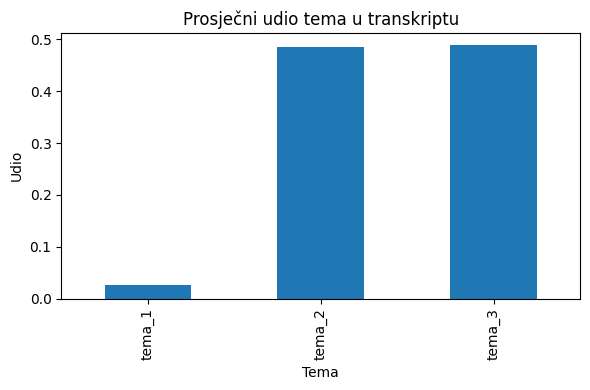

In [21]:
mean_topics = df[[c for c in df.columns if c.startswith("tema_")]].mean()

plt.figure(figsize=(6,4))
mean_topics.plot(kind="bar")
plt.title("Prosječni udio tema u transkriptu")
plt.xlabel("Tema")
plt.ylabel("Udio")
plt.tight_layout()
plt.show()


Dobivene teme interpretiraju se na temelju riječi s najvećom težinom po temi.
Udio tema po segmentima transkripta pokazuje kako se sadržaj govora raspoređuje
između različitih tematskih cjelina. Budući da se radi o kratkom transkriptu,
teme mogu biti manje stabilne, pa je interpretaciju potrebno promatrati kvalitativno.


# **ZADACI ZA VJEŽBU**

## **Zadatak 1: Učitavanje audio i pretvorba govora u tekst (ASR) za engleski govor**

Snimite vlastiti audio zapis u trajanju 30–60 sekundi na engleskom jeziku ili preuzmite kratki engleski audio (npr. isječak govora, kratko objašnjenje neke teme).

Spremite datoteku u format .wav ili .mp3 i prenesite je u radni direktorij bilježnice.

Učitajte audio datoteku u Python i napravite transkripciju (pretvorbu govora u tekst) pomoću ASR alata (Whisper).

Ručno preslušajte audio i usporedite ga s dobivenim transkriptom te, ukoliko postoje, izdvojite neke riječi ili izraze koji su pogrešno prepoznati ili izostavljeni.
Kako bi ti problemi mogli utjecati na daljnju analizu teksta?

In [22]:
!pip -q install gensim nltk matplotlib

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from gensim import corpora
from gensim.models import LdaModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 23.2 MB/s eta 0:00:00


In [23]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

AUDIO_PATH = Path("sample_data/sample_clip.wav")

print("Putanja:", AUDIO_PATH.resolve())
print("Postoji?", AUDIO_PATH.exists())

Audio(filename=str(AUDIO_PATH))


Putanja: /content/sample_data/sample_clip.wav
Postoji? True


In [26]:
import speech_recognition as sr
from pydub import AudioSegment
from pathlib import Path

r = sr.Recognizer()

audio_file_path = Path(AUDIO_PATH)

if audio_file_path.suffix.lower() == ".mp3":
    print("Converting MP3 to WAV...")
    audio = AudioSegment.from_mp3(audio_file_path)
    wav_path = audio_file_path.with_suffix(".wav")
    audio.export(wav_path, format="wav")
    audio_file_path = wav_path
    print(f"Converted to {wav_path}")

with sr.AudioFile(str(audio_file_path)) as source:
    audio_data = r.record(source)

transcript = r.recognize_google(audio_data, language="en-US")
print(transcript)

his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we glanced at him stealthily over the tops of our slates the next day in school he knew we were watching him and made sundry mouths


## **Zadatak 2: Usporedba dviju verzija predobrade teksta**

U ovom zadatku potrebno je napraviti dvije različite verzije očišćenog teksta.


1.   osnovna normalizacija (lowercase + uklanjanje interpunkcije)
2.   puna predobrada (tokenizacija, stopwords, lematizacija/stemming)


Za obje verzije:

*   ispišite prvih 200 znakova
*   izračunajte broj riječi


Kolika je razlika u duljini teksta između verzija te koja je prikladnija za tematsku analizu i zašto?


In [27]:
def version_A_basic(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)   # ukloni sve osim slova i razmaka
    text = re.sub(r"\s+", " ", text).strip()
    return text

text_A = version_A_basic(transcript)
print("VERZIJA A (prvih 200 znakova):")
print(text_A[:200])

words_A = text_A.split()
print("\nBroj riječi (A):", len(words_A))

VERZIJA A (prvih 200 znakova):
his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we glanced at him stealthily over the tops of our slates the next day in school he knew we were watching him 

Broj riječi (A): 45


In [28]:
def version_B_full(text):
    # normalizacija
    text = version_A_basic(text)

    # tokenizacija
    tokens = word_tokenize(text)

    # stopwords (eng)
    sw = set(stopwords.words("english"))

    # lematizacija
    lem = WordNetLemmatizer()

    cleaned = []
    for t in tokens:
        if t in sw:
            continue
        if len(t) < 2:
            continue
        cleaned.append(lem.lemmatize(t))

    return " ".join(cleaned)

text_B = version_B_full(transcript)
print("VERZIJA B (prvih 200 znakova):")
print(text_B[:200])

words_B = text_B.split()
print("\nBroj riječi (B):", len(words_B))

VERZIJA B (prvih 200 znakova):
red hair seemed change lively red shallow cheek deeper sallow glanced stealthily top slate next day school knew watching made sundry mouth

Broj riječi (B): 22


In [29]:
diff = len(words_A) - len(words_B)
print("Razlika u broju riječi (A - B):", diff)

Razlika u broju riječi (A - B): 23


## **Zadatak 3: Utjecaj broja tema na LDA rezultate**

Primijenite LDA nad istim očišćenim tekstom, ali za različite vrijednosti:

*  K = 2
*  K = 3
*  K = 4


Za svaku vrijednost K ispišite 6–8 najvažnijih riječi po temi.

Odaberite jednu vrijednost K koja po vašem mišljenju daje najbolje rezultate.

Što se događa s temama kada je K prevelik ili premalen?

Odabrao/la sam K=3 jer teme djeluju dovoljno specifično, ali se ne raspadaju na previše sitnih grupa riječi.
Kad je K premalen (npr. 2), teme se često pomiješaju i postanu preširoke.
Kad je K prevelik (npr. 4 ili više za kratak tekst), teme postanu nestabilne i sadrže slučajne riječi.

In [30]:
from gensim import corpora
from gensim.models import LdaModel

def lda_topics_from_text(clean_text, k, num_words=7):
    tokens = clean_text.split()

    texts = [tokens]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(t) for t in texts]

    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=20
    )

    print(f"\nLDA za K={k}")
    topics = lda.show_topics(num_topics=k, num_words=num_words, formatted=False)
    for topic_id, words in topics:
        top_words = [w for (w, p) in words]
        print(f"Topic {topic_id}: {', '.join(top_words)}")

    return lda

lda2 = lda_topics_from_text(text_B, k=2, num_words=7)
lda3 = lda_topics_from_text(text_B, k=3, num_words=7)
lda4 = lda_topics_from_text(text_B, k=4, num_words=7)



LDA za K=2
Topic 0: red, change, glanced, cheek, lively, shallow, hair
Topic 1: red, mouth, top, seemed, school, deeper, made

LDA za K=3
Topic 0: red, glanced, sallow, hair, sundry, cheek, change
Topic 1: red, seemed, made, top, watching, mouth, sundry
Topic 2: red, next, deeper, change, slate, stealthily, lively

LDA za K=4
Topic 0: red, sallow, glanced, shallow, hair, watching, lively
Topic 1: red, top, seemed, watching, deeper, school, sallow
Topic 2: red, deeper, school, stealthily, shallow, sallow, next
Topic 3: red, knew, sundry, mouth, cheek, next, change


##**Zadatak 4: Usporedba tema prije i poslije predobrade**

1. Primijenite LDA:

    * jednom na neobrađeni transkript

    * jednom na potpuno očišćeni tekst

2. Vizualizirajte teme u oba slučaja.

3. Usporedite:

    * koje riječi dominiraju u temama

    * pojavljuju li se neinformativne riječi


Kako predobrada utječe na interpretabilnost tema?
Bi li se LDA uopće trebao primjenjivati bez predobrade?

In [31]:
def basic_normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def make_docs_before(transcript, min_len=5):
    # BEFORE: samo osnovna normalizacija + tokeni po rečenicama
    sentences = nltk.sent_tokenize(transcript)
    docs = []
    for s in sentences:
        s = basic_normalize(s)
        toks = s.split()
        if len(toks) >= min_len:
            docs.append(toks)
    return docs

def make_docs_after(transcript, min_len=5):
    # AFTER: tokeni + stopwords + lematizacija po rečenicama
    sw = set(stopwords.words("english"))
    lem = WordNetLemmatizer()

    sentences = nltk.sent_tokenize(transcript)
    docs = []
    for s in sentences:
        s = basic_normalize(s)
        toks = s.split()

        cleaned = []
        for t in toks:
            if t in sw:
                continue
            if len(t) < 2:
                continue
            cleaned.append(lem.lemmatize(t))

        if len(cleaned) >= min_len:
            docs.append(cleaned)

    return docs

docs_before = make_docs_before(transcript)
docs_after  = make_docs_after(transcript)

print("Broj pseudo-dokumenata (BEFORE):", len(docs_before))
print("Broj pseudo-dokumenata (AFTER):", len(docs_after))


Broj pseudo-dokumenata (BEFORE): 1
Broj pseudo-dokumenata (AFTER): 1


In [32]:
def train_lda(docs, num_topics=3, passes=25):
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(d) for d in docs]

    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=passes
    )
    return lda

K = 3
lda_before = train_lda(docs_before, num_topics=K, passes=25)
lda_after  = train_lda(docs_after,  num_topics=K, passes=25)


In [35]:
def print_lda_topics(lda_model, title, topn=10):
    print("=" * 60)
    print(title)
    print("=" * 60)

    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, topn=topn)
        word_list = [w for (w, _) in words]
        print(f"Topic {topic_id}: {', '.join(word_list)}")

    print()


print_lda_topics(
    lda_before,
    title="LDA TEME PRIJE PREOBRADE (BEFORE)",
    topn=10
)

print_lda_topics(
    lda_after,
    title="LDA TEME NAKON PREOBRADE (AFTER)",
    topn=10
)




LDA TEME PRIJE PREOBRADE (BEFORE)
Topic 0: to, we, the, his, him, a, and, red, change, our
Topic 1: to, red, watching, him, hair, day, of, and, cheeks, made
Topic 2: to, red, and, a, the, his, him, we, hair, as

LDA TEME NAKON PREOBRADE (AFTER)
Topic 0: glanced, red, sallow, hair, sundry, cheek, change, shallow, lively, watching
Topic 1: red, seemed, made, top, watching, mouth, sundry, school, day, sallow
Topic 2: red, next, deeper, change, slate, stealthily, lively, school, cheek, shallow



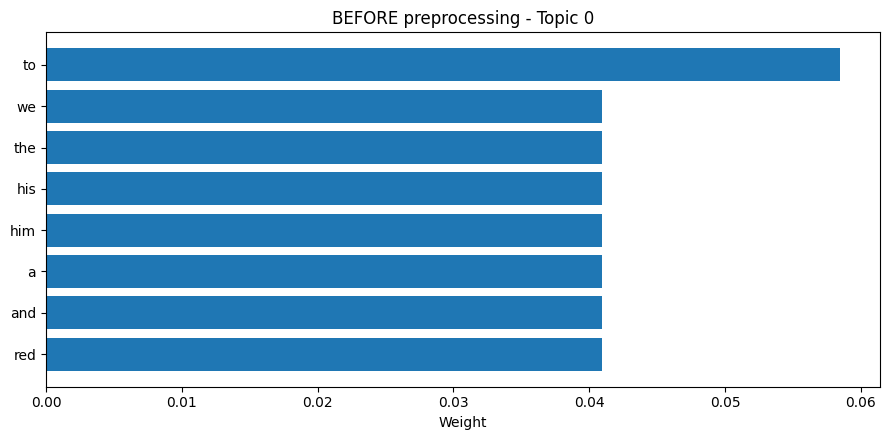

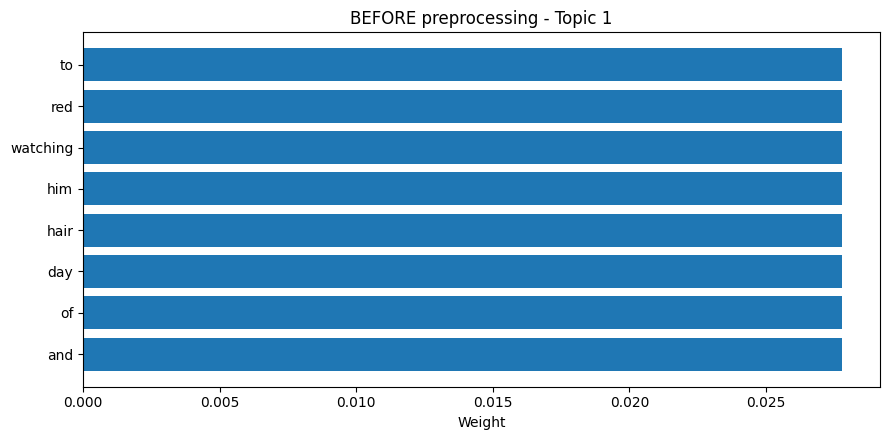

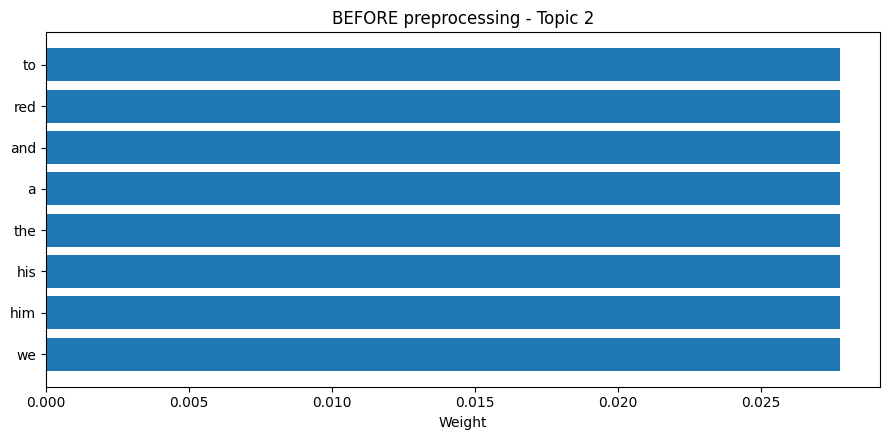

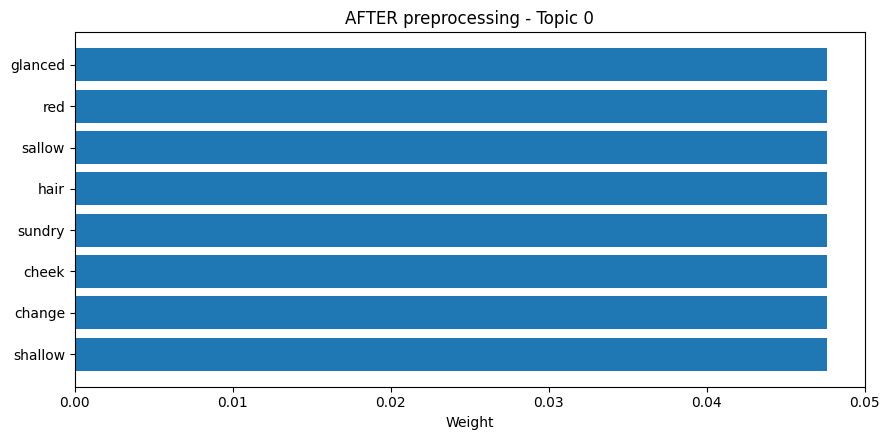

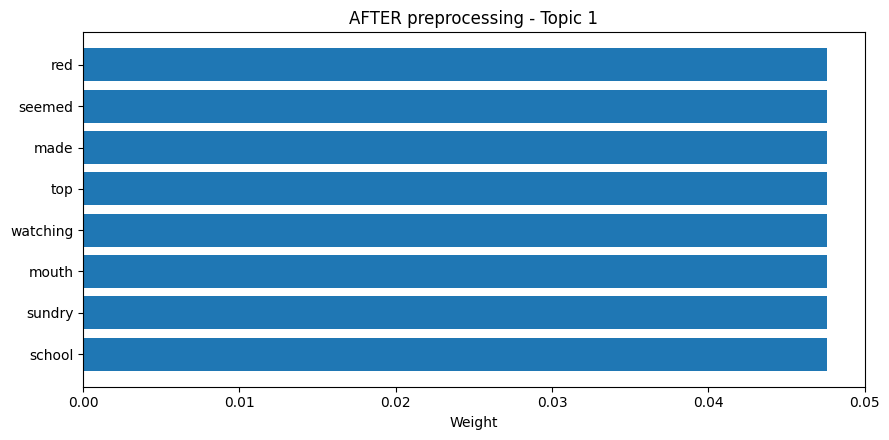

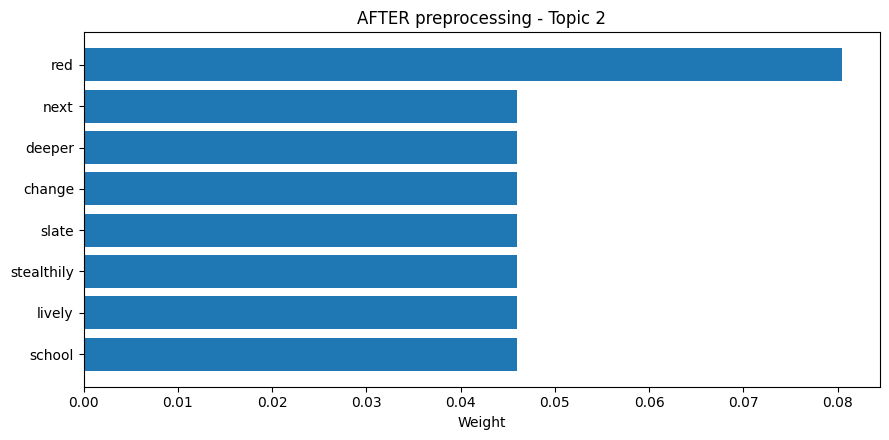

In [36]:
def plot_lda_topics(lda_model, title_prefix, topn=8):
    # show_topic vraća listu (word, weight)
    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, topn=topn)

        # sortiraj da je najveće gore
        labels = [w for (w, p) in words][::-1]
        weights = [p for (w, p) in words][::-1]

        plt.figure(figsize=(9, 4.5))
        plt.barh(labels, weights)
        plt.title(f"{title_prefix} - Topic {topic_id}")
        plt.xlabel("Weight")
        plt.tight_layout()
        plt.show()

plot_lda_topics(lda_before, "BEFORE preprocessing", topn=8)
plot_lda_topics(lda_after,  "AFTER preprocessing",  topn=8)
